# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
#from pmdarima import auto_arima                              # for determining ARIMA orders

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error, accuracy_score
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")

# Load the data 

In [2]:
# source:https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data
aoti=pd.read_csv('PRSA_Data_Aotizhongxin_20130301-20170228.csv')
changping=pd.read_csv('PRSA_Data_Changping_20130301-20170228.csv')
dingling=pd.read_csv('PRSA_Data_Dingling_20130301-20170228.csv')
dongsi=pd.read_csv('PRSA_Data_Dongsi_20130301-20170228.csv')
guanyuan=pd.read_csv( 'PRSA_Data_Guanyuan_20130301-20170228.csv')   
gucheng=pd.read_csv( 'PRSA_Data_Gucheng_20130301-20170228.csv' ) 
huairou=pd.read_csv( 'PRSA_Data_Huairou_20130301-20170228.csv' )  
nongzhanguan=pd.read_csv('PRSA_Data_Nongzhanguan_20130301-20170228.csv')
shunyi=pd.read_csv('PRSA_Data_Shunyi_20130301-20170228.csv')     
tiantan=pd.read_csv('PRSA_Data_Tiantan_20130301-20170228.csv') 
wanliu=pd.read_csv('PRSA_Data_Wanliu_20130301-20170228.csv' ) 
wanshouxi=pd.read_csv('PRSA_Data_Wanshouxigong_20130301-20170228.csv' )

In [3]:
# check one of those datasets 
aoti.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [4]:
tiantan.columns

Index(['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2',
       'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station'],
      dtype='object')

`Attribute Information:`

- No: row number
- year: year of data in this row
- month: month of data in this row
- day: day of data in this row
- hour: hour of data in this row
- PM2.5: PM2.5 concentration (ug/m^3)
  `PM2.5 is a kind of PM10, they are inclusive relationships, PM2.5     generally accounts for about 70% of PM10.`
- PM10: PM10 concentration (ug/m^3)
- SO2: SO2 concentration (ug/m^3)
- NO2: NO2 concentration (ug/m^3)
- CO: CO concentration (ug/m^3)
- O3: O3 concentration (ug/m^3)
- TEMP: temperature (degree Celsius)
- PRES: pressure (hPa)
- DEWP: dew point temperature (degree Celsius)
- RAIN: precipitation (mm)
- wd: wind direction
- WSPM: wind speed (m/s)
- station: name of the air-quality monitoring site

In [5]:
# since PM2.5 is a kind of PM10, they are inclusive relationships, PM2.5     
#generally accounts for about 70% of PM10.
# We will only use PM 2.5 as our target

In [6]:
# create a list for all of them 
datasets=[aoti,changping,dingling,dongsi,guanyuan,gucheng,huairou,
          nongzhanguan,shunyi,tiantan,wanliu,wanshouxi]

In [7]:
# create a list of names for all datasets
datasets_name=['aoti','changping','dingling','dongsi','guanyuan','gucheng','huairou',
          'nongzhanguan','shunyi','tiantan','wanliu','wanshouxi']

In [8]:
# check those tabls size 
for data in datasets:
    print(data.shape)

(35064, 18)
(35064, 18)
(35064, 18)
(35064, 18)
(35064, 18)
(35064, 18)
(35064, 18)
(35064, 18)
(35064, 18)
(35064, 18)
(35064, 18)
(35064, 18)


In [9]:
#  check if all the columns of those datasets are same
col=[data.columns for data in datasets]
for i in range(1,len(col)):
    print(col[0]==col[i])

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[

In [10]:
# check rows 
# Check if the date in each data has the same order. 

date=[]
for data in datasets:
    date.append(data[['year','month','day']])
for i in range(1,len(date)):
     print(date[0]==date[i])

       year  month   day
0      True   True  True
1      True   True  True
2      True   True  True
3      True   True  True
4      True   True  True
...     ...    ...   ...
35059  True   True  True
35060  True   True  True
35061  True   True  True
35062  True   True  True
35063  True   True  True

[35064 rows x 3 columns]
       year  month   day
0      True   True  True
1      True   True  True
2      True   True  True
3      True   True  True
4      True   True  True
...     ...    ...   ...
35059  True   True  True
35060  True   True  True
35061  True   True  True
35062  True   True  True
35063  True   True  True

[35064 rows x 3 columns]
       year  month   day
0      True   True  True
1      True   True  True
2      True   True  True
3      True   True  True
4      True   True  True
...     ...    ...   ...
35059  True   True  True
35060  True   True  True
35061  True   True  True
35062  True   True  True
35063  True   True  True

[35064 rows x 3 columns]
       year  month   d

# Data Cleaning

In [11]:
# check missing values for each data 
missing_info=pd.DataFrame(data.isnull().sum() for data in datasets).T
missing_info.columns=datasets_name
missing_info

,aoti,changping,dingling,dongsi,guanyuan,gucheng,huairou,nongzhanguan,shunyi,tiantan,wanliu,wanshouxi
No,0,0,0,0,0,0,0,0,0,0,0,0
year,0,0,0,0,0,0,0,0,0,0,0,0
month,0,0,0,0,0,0,0,0,0,0,0,0
day,0,0,0,0,0,0,0,0,0,0,0,0
hour,0,0,0,0,0,0,0,0,0,0,0,0
PM2.5,925,774,779,750,616,646,953,628,913,677,382,696
PM10,718,582,656,553,429,381,777,440,548,597,284,484
SO2,935,628,730,663,474,507,980,446,1296,1118,575,669
NO2,1023,667,1234,1601,659,668,1639,692,1365,744,1070,754
CO,1776,1521,2012,3197,1753,1401,1422,1206,2178,1126,1812,1297


## fill out the missing data for time series
- For time series, you don't want to replace missing values with the mean of the series. Here we used `Forward Fill` to fill out the missing data (numerical data)
- source:https://www.machinelearningplus.com/time-series/time-series-analysis-python/

In [12]:
# fill out the numertical and catogorical data at the sametime using 
##  Backward Fill method
def Backward_Fill(data,col):
    return data[col].bfill()

In [13]:
feature_names=['PM2.5', 'PM10', 'SO2', 'NO2','CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station']


In [14]:
#  using loop to fill the missing data 
for data in datasets:
    for col in feature_names:
        data[col]=Backward_Fill(data,col)

In [15]:
# double check missing values
missing_table=pd.DataFrame(data.isnull().sum() for data in datasets).T
missing_table.columns=datasets_name
missing_table

,aoti,changping,dingling,dongsi,guanyuan,gucheng,huairou,nongzhanguan,shunyi,tiantan,wanliu,wanshouxi
No,0,0,0,0,0,0,0,0,0,0,0,0
year,0,0,0,0,0,0,0,0,0,0,0,0
month,0,0,0,0,0,0,0,0,0,0,0,0
day,0,0,0,0,0,0,0,0,0,0,0,0
hour,0,0,0,0,0,0,0,0,0,0,0,0
PM2.5,0,0,0,0,0,0,0,0,0,0,0,0
PM10,0,0,0,0,0,0,0,0,0,0,0,0
SO2,0,0,0,0,0,0,0,0,0,0,0,0
NO2,0,0,0,0,0,0,0,0,0,0,0,0
CO,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
# since all datasets have same row_size , 
#columns and 'year' we can merge all data together
combined_data= pd.concat(datasets).drop(columns='PM10')

In [17]:
# there are 12*35064=420768 rows
combined_data.shape 

(420768, 17)

In [18]:
# check first five rows we can see 
combined_data.head()

,No,year,month,day,hour,PM2.5,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [19]:
# #We can see year,month,day,hour
# col_list=['No','year','month','day','hour']
# for i in col_list:
#     combined_data[i]=combined_data[i].apply(lambda x: int(x))

In [20]:
# double check No,year,month,day,hour if they are converted from 'float' into 'int'
combined_data.head()

,No,year,month,day,hour,PM2.5,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [21]:
#Double check missing value
combined_data.isnull().sum()

No         0
year       0
month      0
day        0
hour       0
PM2.5      0
SO2        0
NO2        0
CO         0
O3         0
TEMP       0
PRES       0
DEWP       0
RAIN       0
wd         0
WSPM       0
station    0
dtype: int64

In [22]:
combined_data.head()

,No,year,month,day,hour,PM2.5,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


# EDA 

In [23]:
# groupby year/month/day/hour and obtian the average from all stations
yearly=combined_data.groupby(['year','month'])['PM2.5'].mean()
monthly=pd.DataFrame(combined_data.groupby(['month','day'])['PM2.5'].mean())
daily=pd.DataFrame(combined_data.groupby(['day','hour'])['PM2.5'].mean())
hourly=pd.DataFrame(combined_data.groupby('hour')['PM2.5'].mean())

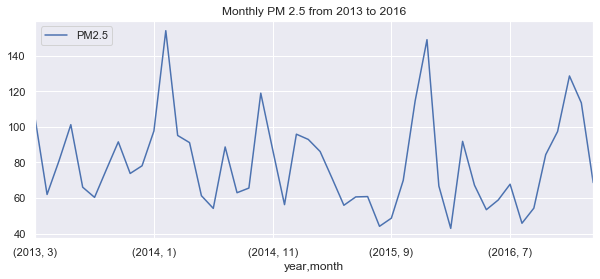

In [24]:
# Beijing pm 2.5 monthly changes from 2013-2017 (mean of all stations' data)
yearly.plot(figsize=(10,4),title='Monthly PM 2.5 from 2013 to 2016')
plt.legend(loc='upper left')

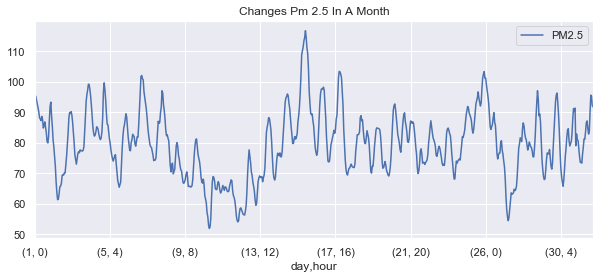

In [25]:
# plot pm 2.5 from 1st to 30st day of a month 
daily.plot(figsize=(10,4),title='Changes PM 2.5 in a month'.title())
plt.show()

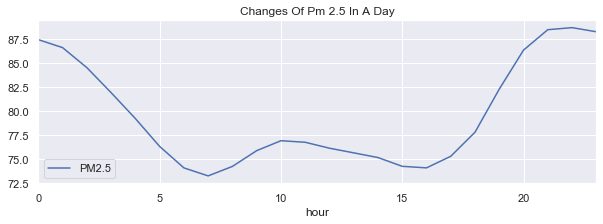

In [26]:
# changes of pm 2.5 in a day 
hourly.plot(figsize=(10,3),title='Changes of pm 2.5 in a day'.title())
plt.show()

In [27]:
# obtian a table for mean of each variables from all stations 
table=combined_data.groupby(['year','month','day'])['PM2.5', 'SO2', 'NO2', 'CO', 'O3',
       'TEMP', 'PRES', 'DEWP', 'RAIN',  'WSPM' ].mean()
# create a list for different colors 
color=['b','g','r','b','c','m','y','k','b','g','pink','g','y']

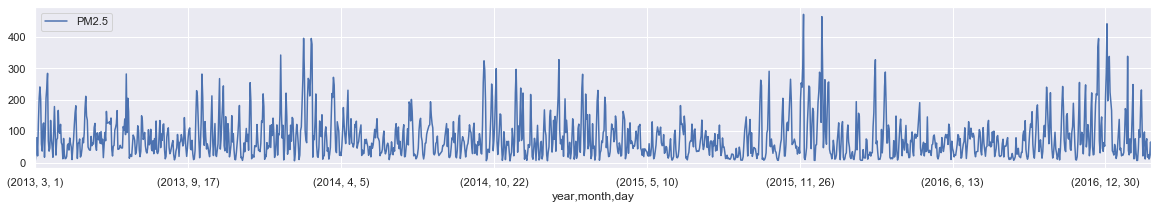

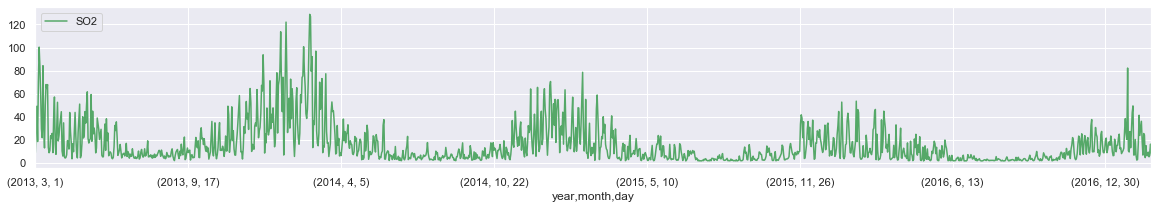

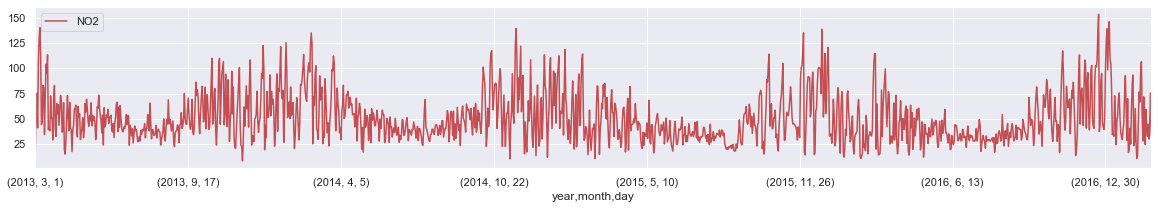

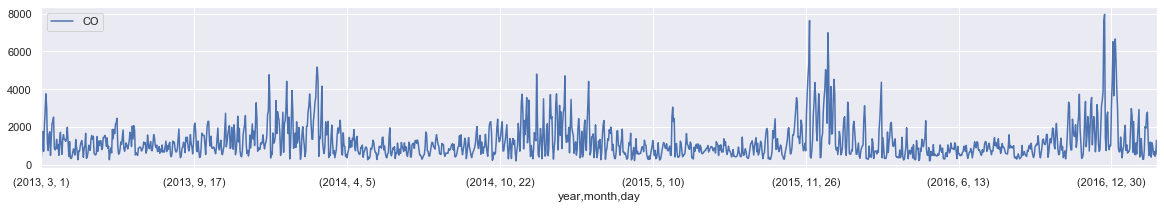

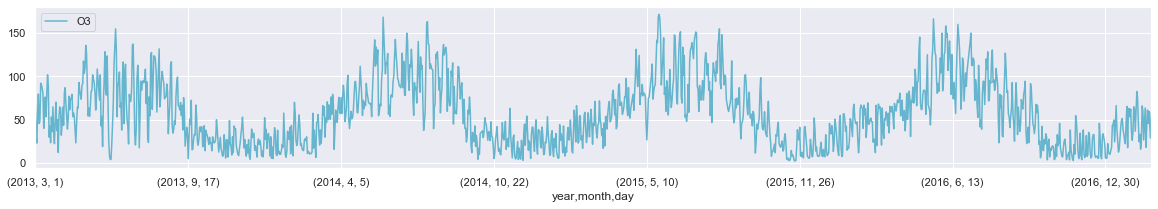

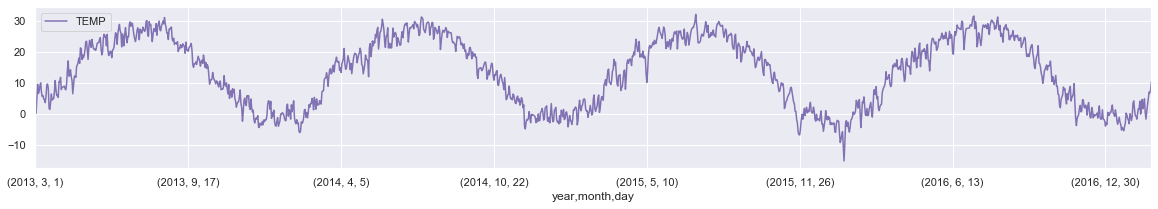

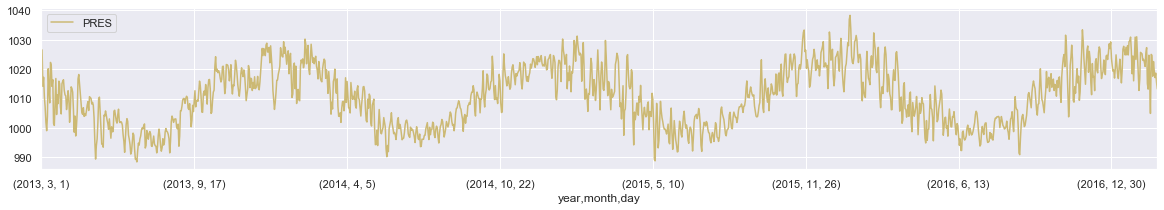

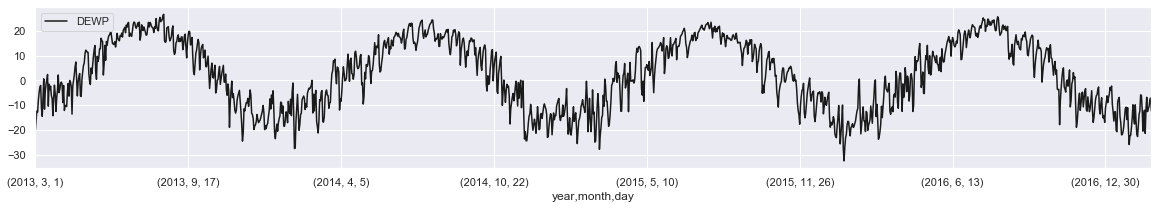

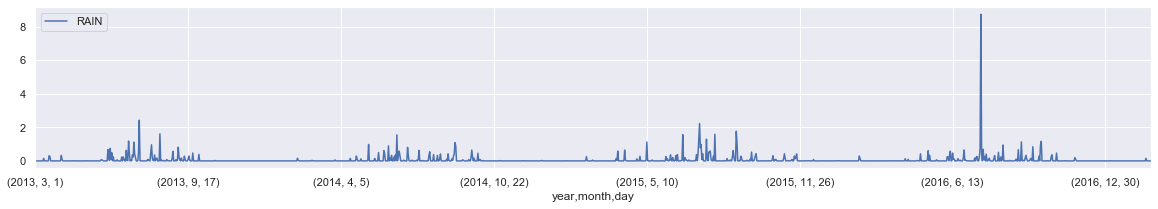

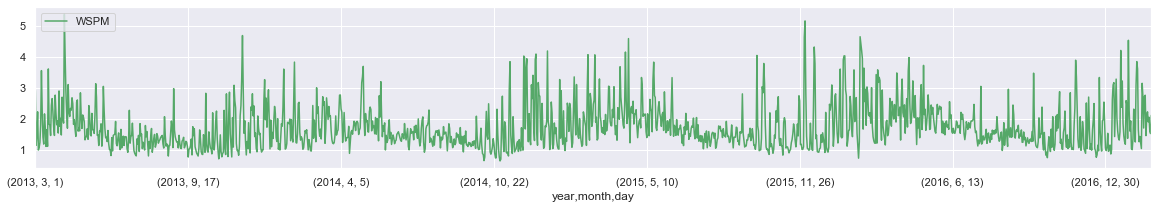

In [28]:
for i in range(len(table.columns)):
    plt.subplot(len(table.columns),1,i+1)
    table[table.columns[i]].plot(figsize=(20,35),label=table.columns[i],color=color[i])
    plt.legend(loc='upper left')
    plt.show()

In [29]:
# create a list for all stations
stations=['Aotizhongxin',
  'Changping',
  'Dingling',
  'Dongsi',
  'Guanyuan',
  'Gucheng',
  'Huairou',
  'Nongzhanguan',
  'Shunyi',
  'Tiantan',
  'Wanliu',
  'Wanshouxigong']

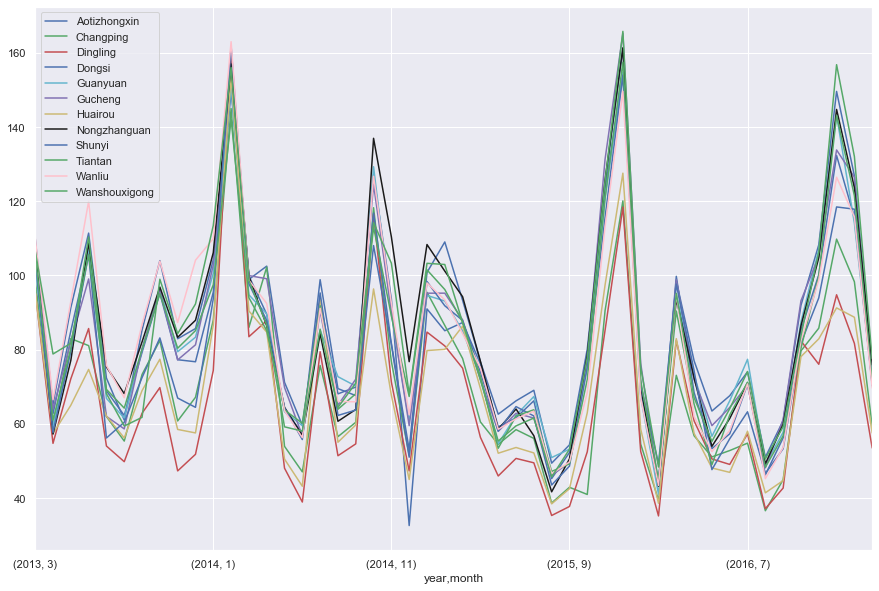

In [31]:
# plot PM 2.5 in different stations
plt.figure(figsize=(15,10))

for i in range(0,12):  
    #plt.subplot(12,1,i+1)
    combined_data[combined_data['station']==stations[i]].groupby(['year','month'])['PM2.5'].mean().plot(label=stations[i],color=color[i])
plt.legend(loc='upper left')
plt.show()

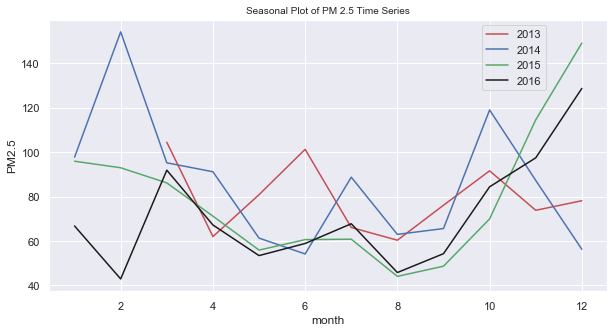

In [32]:
# seasonal polt of PM2.5 in dfferent years
table1=pd.DataFrame(combined_data.groupby(['year','month'])['PM2.5'].mean()).reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(table1[table1['year']==2013]['month'],table1[table1['year']==2013]['PM2.5'],label='2013',color='r')
sns.lineplot(table1[table1['year']==2014]['month'],table1[table1['year']==2014]['PM2.5'],label='2014',color='b')
sns.lineplot(table1[table1['year']==2015]['month'],table1[table1['year']==2015]['PM2.5'],label='2015',color='g')
sns.lineplot(table1[table1['year']==2016]['month'],table1[table1['year']==2016]['PM2.5'],label='2016',color='k')
plt.legend(loc=1,bbox_to_anchor=(0.9, 1))
plt.title("Seasonal Plot of PM 2.5 Time Series", fontsize=10)
plt.show()

# Unit Root test (Stationary test)

In [33]:
# create a dataframe for pm2.5 monthly change from 2013-2017
df_month=combined_data.groupby(['year','month'])['PM2.5'].mean().reset_index()
df_month['dateInt']=df_month['year'].astype(str) + df_month['month'].astype(str).str.zfill(2)
df_month['Date'] = pd.to_datetime(df_month['dateInt'], format='%Y%m')
df_month=df_month.set_index('Date')
df_month.head()


,year,month,PM2.5,dateInt
Date,,,,
2013-03-01,2013,3,104.466062,201303
2013-04-01,2013,4,61.987731,201304
2013-05-01,2013,5,80.839830,201305
2013-06-01,2013,6,101.279225,201306
2013-07-01,2013,7,66.071237,201307


In [34]:
from statsmodels.tsa.stattools import adfuller, kpss

#create a function that will help us to quickly 
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


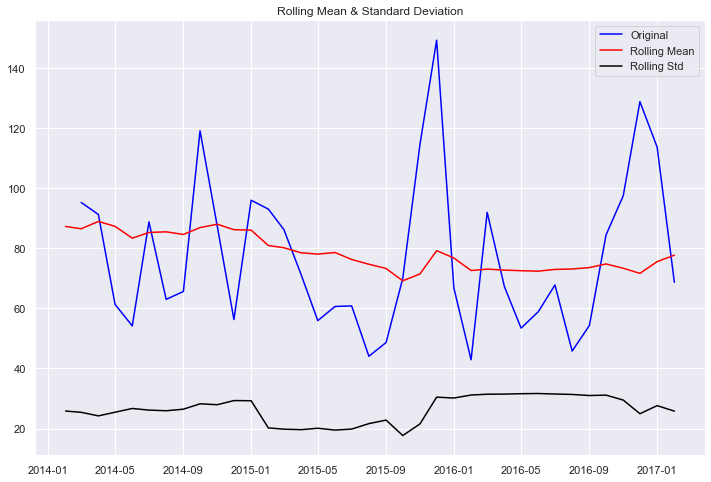

Results of Dickey-Fuller Test:
Test Statistic                 -5.032007
p-value                         0.000019
#Lags Used                      1.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
dtype: float64


In [35]:
#test the stationarity of the monthly_data from 2014
test_stationarity(df_month['PM2.5'],12)

`Augmented Dickey Fuller test (ADH Test)`
- The null hypothesis is the time series possesses a unit root and is non-stationary. So, if the P-Value in ADH test is less than the significance level (0.05), we will reject the null hypothesis.

- source:https://www.machinelearningplus.com/time-series/time-series-analysis-python/

In [36]:
# Function for ADF Test
def ADF_test(data):
    result = adfuller(data.values, autolag='AIC')
    print(f'p-value: {result[1]}')
    if result[1]<0.05:
        print('Reject the null hypothesis! ' + 'The time series is stationary!')
    else:
        print('Accept the null hypothesis! ' + 'The time series is non-stationary!')

In [39]:
# check if each station's data is stationary
for station in stations:
    data=combined_data[combined_data['station']==station]['PM2.5']
    print({station:ADF_test(data)})

p-value: 0.0
Reject the null hypothesis! The time series is stationary!
{'Aotizhongxin': None}
p-value: 0.0
Reject the null hypothesis! The time series is stationary!
{'Changping': None}
p-value: 0.0
Reject the null hypothesis! The time series is stationary!
{'Dingling': None}
p-value: 0.0
Reject the null hypothesis! The time series is stationary!
{'Dongsi': None}
p-value: 0.0
Reject the null hypothesis! The time series is stationary!
{'Guanyuan': None}
p-value: 2.0237367551008417e-30
Reject the null hypothesis! The time series is stationary!
{'Gucheng': None}
p-value: 0.0
Reject the null hypothesis! The time series is stationary!
{'Huairou': None}
p-value: 0.0
Reject the null hypothesis! The time series is stationary!
{'Nongzhanguan': None}
p-value: 0.0
Reject the null hypothesis! The time series is stationary!
{'Shunyi': None}
p-value: 0.0
Reject the null hypothesis! The time series is stationary!
{'Tiantan': None}
p-value: 0.0
Reject the null hypothesis! The time series is stationar

`Since monthly_data and the data for each station is stationary then We dont need to transform the data`

# Autocorrelation 

In [37]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Autocorrelation is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

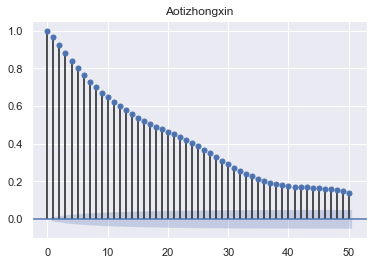

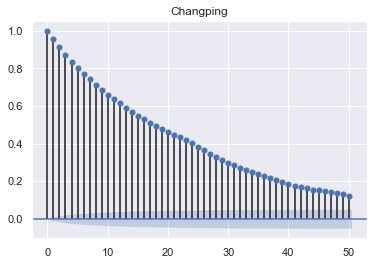

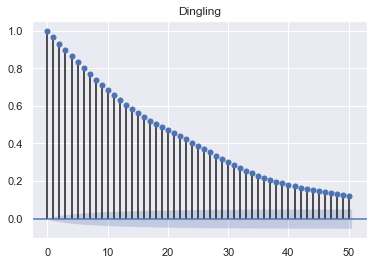

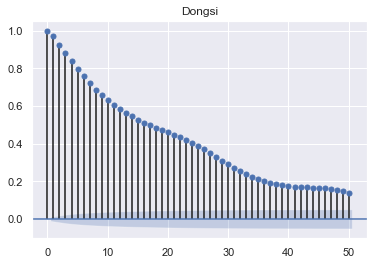

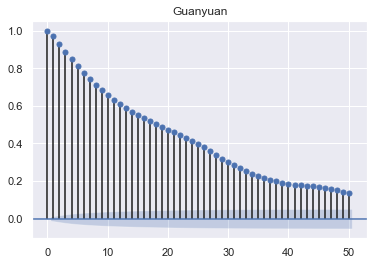

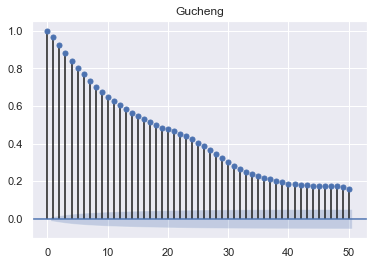

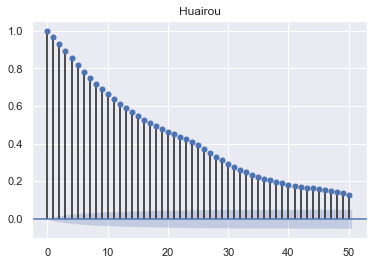

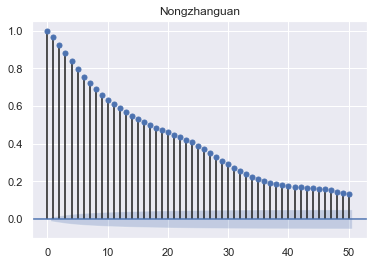

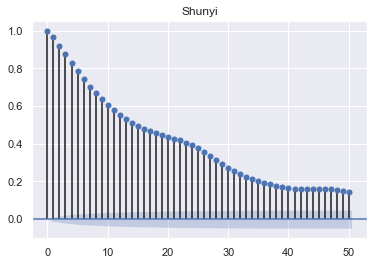

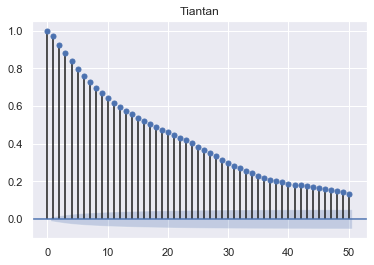

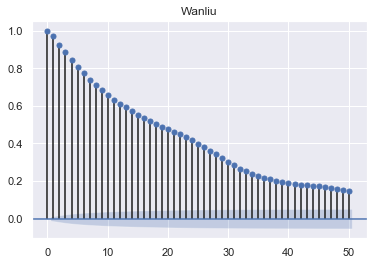

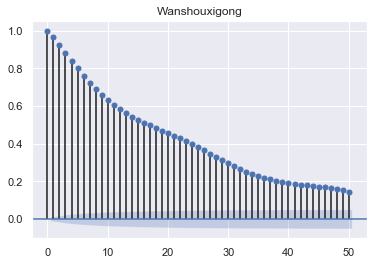

In [49]:
for i in range(0,len(stations)):
    df=combined_data[combined_data['station']==stations[i]]['PM2.5']
    plot_acf(df.tolist(), lags=50)
    plt.title(stations[i])

# Components of Time Series Data

<Figure size 432x288 with 0 Axes>

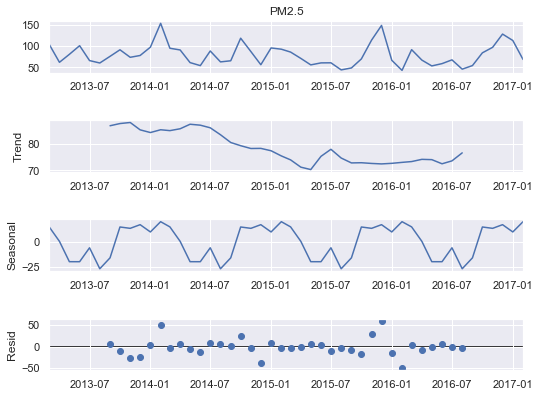

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose
# obtain components of time series data
decomposition = seasonal_decompose(df_month['PM2.5'], freq=12 )
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(8, 6)
plt.show()

# Create date column and reset index 

In [39]:
# # add a new column called 'date' which is combined year month day and hour
date=pd.DataFrame()
date['dateint']=combined_data['year'].astype(str) + combined_data['month'].astype(str).str.zfill(2)+ combined_data['day'].astype(str).str.zfill(2)+combined_data['hour'].astype(str).str.zfill(2)
date['date'] = pd.to_datetime(date['dateint'], format='%Y%m%d%H')
combined_data['date']=date['date'] 

In [40]:
combined_data.head(2)

,No,year,month,day,hour,PM2.5,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,date
0,1,2013,3,1,0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,2013-03-01 00:00:00
1,2,2013,3,1,1,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,2013-03-01 01:00:00


In [41]:
# reset index 
combined_data=combined_data.set_index(['station','date'])

In [42]:
# wd is not
my_data=combined_data.drop(columns=['No','day','hour','wd']).copy()

In [43]:
my_data.head()

year  month  PM2.5   SO2   NO2     CO    O3  \
station      date                                                               
Aotizhongxin 2013-03-01 00:00:00  2013      3    4.0   4.0   7.0  300.0  77.0   
             2013-03-01 01:00:00  2013      3    8.0   4.0   7.0  300.0  77.0   
             2013-03-01 02:00:00  2013      3    7.0   5.0  10.0  300.0  73.0   
             2013-03-01 03:00:00  2013      3    6.0  11.0  11.0  300.0  72.0   
             2013-03-01 04:00:00  2013      3    3.0  12.0  12.0  300.0  72.0   

                                  TEMP    PRES  DEWP  RAIN  WSPM  
station      date                                                 
Aotizhongxin 2013-03-01 00:00:00  -0.7  1023.0 -18.8   0.0   4.4  
             2013-03-01 01:00:00  -1.1  1023.2 -18.2   0.0   4.7  
             2013-03-01 02:00:00  -1.1  1023.5 -18.2   0.0   5.6  
             2013-03-01 03:00:00  -1.4  1024.5 -19.4   0.0   3.1  
             2013-03-01 04:00:00  -2.0  1025.2 -19.5   0.0   2.0

# Data Standardization

In [44]:
from sklearn.preprocessing import MinMaxScaler

In [45]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(my_data[[ 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES',
       'DEWP', 'RAIN', 'WSPM' ]])

In [46]:
scaled_df=pd.DataFrame(data=scaled,columns=[ 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES',
       'DEWP', 'RAIN', 'WSPM' ])
scaled_df.head()

,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
0,0.007433,0.020671,0.020202,0.071710,0.312195,0.672185,0.339310,0.0,0.333333
1,0.007433,0.020671,0.020202,0.071710,0.305691,0.675497,0.347586,0.0,0.356061
2,0.009434,0.031053,0.020202,0.067974,0.305691,0.680464,0.347586,0.0,0.424242
3,0.021441,0.034514,0.020202,0.067040,0.300813,0.697020,0.331034,0.0,0.234848
4,0.023442,0.037974,0.020202,0.067040,0.291057,0.708609,0.329655,0.0,0.151515


In [47]:
# drop un_scaled data from my data
My_data=my_data.drop(columns=[ 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES',
       'DEWP', 'RAIN', 'WSPM' ]).reset_index()


In [48]:
# get the column of date
sta=My_data['station']

In [49]:
scaled_df.head()

,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
0,0.007433,0.020671,0.020202,0.071710,0.312195,0.672185,0.339310,0.0,0.333333
1,0.007433,0.020671,0.020202,0.071710,0.305691,0.675497,0.347586,0.0,0.356061
2,0.009434,0.031053,0.020202,0.067974,0.305691,0.680464,0.347586,0.0,0.424242
3,0.021441,0.034514,0.020202,0.067040,0.300813,0.697020,0.331034,0.0,0.234848
4,0.023442,0.037974,0.020202,0.067040,0.291057,0.708609,0.329655,0.0,0.151515


In [50]:
#combine with scaled_df 
My_data[scaled_df.columns]=scaled_df

In [51]:
My_data=My_data.set_index(['station','date'])

In [52]:
My_data['station']=np.array(sta)
My_data.head(3)

year  month  PM2.5       SO2       NO2  \
station      date                                                          
Aotizhongxin 2013-03-01 00:00:00  2013      3    4.0  0.007433  0.020671   
             2013-03-01 01:00:00  2013      3    8.0  0.007433  0.020671   
             2013-03-01 02:00:00  2013      3    7.0  0.009434  0.031053   

                                        CO        O3      TEMP      PRES  \
station      date                                                          
Aotizhongxin 2013-03-01 00:00:00  0.020202  0.071710  0.312195  0.672185   
             2013-03-01 01:00:00  0.020202  0.071710  0.305691  0.675497   
             2013-03-01 02:00:00  0.020202  0.067974  0.305691  0.680464   

                                      DEWP  RAIN      WSPM       station  
station      date                                                         
Aotizhongxin 2013-03-01 00:00:00  0.339310   0.0  0.333333  Aotizhongxin  
             2013-03-01 01:00:00  0.347586   0.0  0.356061  Aotizhongxin  
             2013-03-01 02:00:00  0.347586   0.0  0.424242  Aotizhongxin

# Train Test Split


In [53]:
def train_test_split(data):
    # for train data will be collected from each station's data which index is from 0-28050 (80%)
    x_train =data.drop(columns=['PM2.5']).iloc[0:28051] 
    # for test data will be collected from each station's data which index is from 28051 to the end (20%)
    x_test = data.drop(columns=['PM2.5']).iloc[28051:]
    y_train=data['PM2.5'].iloc[0:28051] 
    y_test=data['PM2.5'].iloc[28051:] 
    return x_train, x_test,y_train,y_test

In [54]:
# loop each station and collect train and test data 
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0,len(stations)):
    data=My_data[My_data['station']==stations[i]]
    x_train, x_test,y_train,y_test=train_test_split(data)
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

In [55]:
# concat each train data from each station 
X_train=pd.concat(X_train)
# concat each test data from each station 
X_test=pd.concat(X_test)
Y_train=pd.DataFrame(pd.concat(Y_train))
Y_test=pd.DataFrame(pd.concat(Y_test))

In [56]:
X_train=X_train.drop(columns=['station'])
X_test=X_test.drop(columns=['station'])

In [57]:
# double check the train data and test data and our target 
X_test.head(2)

year  month       SO2       NO2        CO  \
station      date                                                             
Aotizhongxin 2016-05-12 19:00:00  2016      5  0.003431  0.058737  0.020202   
             2016-05-12 20:00:00  2016      5  0.003431  0.100264  0.030303   

                                        O3      TEMP      PRES      DEWP  \
station      date                                                          
Aotizhongxin 2016-05-12 19:00:00  0.082916  0.653659  0.485099  0.521379   
             2016-05-12 20:00:00  0.061437  0.606504  0.500000  0.600000   

                                  RAIN      WSPM  
station      date                                 
Aotizhongxin 2016-05-12 19:00:00   0.0  0.166667  
             2016-05-12 20:00:00   0.0  0.045455

In [58]:
Y_test.head(2)

PM2.5
station      date                      
Aotizhongxin 2016-05-12 19:00:00   10.0
             2016-05-12 20:00:00   26.0

In [59]:
len(X_test),len(Y_test)

(84156, 84156)

In [60]:
len(Y_train),len(X_train)

(336612, 336612)

In [61]:
X_test.columns

Index(['year', 'month', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP',
       'RAIN', 'WSPM'],
      dtype='object')

In [63]:
# save test data and train data for LSTM model
X_test.to_csv('X_test_scaled_data.csv') 
X_train.to_csv('X_train_scaled_data.csv')
Y_test.to_csv('Y_test_scaled_data.csv')
Y_train.to_csv('Y_train_scaled_data.csv')

# Models 

## Fixed Effect Estimation 

`Notes`

- The most common included entity effects and can be described

$ y_{it}= α_i+ β′x_{it}+ ϵ_{it} $
where $α_i$ is included if `entity_effects=True`.

- Time effect are also supported, which leads to a model of the form

$y_{it}=γ_t+β′x_{it}+ϵ_{it}$
where γ_i is included if `time_effects=True`.

- Both effects can be simultaneously used,

$ y_{it}=α_i+γ_t+β′x_{it}+ϵ_{it}$


In [64]:
#!pip install linearmodels

In [65]:
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

In [66]:
paneldata=pd.DataFrame()
paneldata[X_train.columns]=X_train
paneldata['Y']=Y_train

In [69]:
#By default a constant is not included, and so if a constant is desired,
#1+ should be included in the formula. 
Fixed=PanelOLS.from_formula('Y ~ 1 + SO2+NO2+CO+O3+TEMP+PRES+DEWP+RAIN+WSPM+EntityEffects', data=paneldata)
fixed_res=Fixed.fit(drop_absorbed=True,cov_type='robust')

In [70]:
fixed_res

Dep. Variable:,Y,R-squared:,0.6755
Estimator:,PanelOLS,R-squared (Between):,-0.6230
No. Observations:,336612,R-squared (Within):,0.6755
Date:,"Sat, Mar 28 2020",R-squared (Overall):,0.6679
Time:,04:12:13,Log-likelihood,-1.764e+06
Cov. Estimator:,Robust,,
,,F-statistic:,7.784e+04
Entities:,12,P-value,0.0000
Avg Obs:,2.805e+04,Distribution:,"F(9,336591)"
Min Obs:,2.805e+04,,
Max Obs:,2.805e+04,F-statistic (robust):,3.784e+04


### train data  prediction

In [71]:
fix_train_pre=np.array(fixed_res.predict()['fitted_values'])
y_train_actual=np.array(Y_train['PM2.5'])

In [72]:
def train_prediction_n_train_actual(model,Y_train):
    train_pre=np.array(model.predict()['fitted_values'])
    y_train_actual=np.array(Y_train['PM2.5'])
    return train_pre,y_train_actual

In [73]:
fixed_train_pre,y_train_actual=train_prediction_n_train_actual(fixed_res,Y_train)

In [74]:
# obtian the standard diviation and  RMSE
def  Std_vs_RMSE(actual,prediction):
    print("Standard Diviation of actual values:{} ".format(actual.std()))
    rmse= np.sqrt(((prediction - actual) ** 2).mean())
    print('RMSE :{}'.format(rmse))

In [75]:
Std_vs_RMSE(y_train_actual,fixed_train_pre)

Standard Diviation of actual values:80.44120645449095 
RMSE :46.35964728428138


In [76]:
# create function to compare prediciton and actual values
def prediciton_vs_actual(x,y_actual,y_prediciton):
    df=pd.DataFrame()
    df[x.columns]=x
    df['actual']=y_actual
    df['prediction']=y_prediciton
    groupby=df.groupby(['year','month'])['actual','prediction'].mean()
    groupby.plot(figsize=(10,5))
    plt.title('Actual VS Prediction')
    plt.legend()
    plt.show()

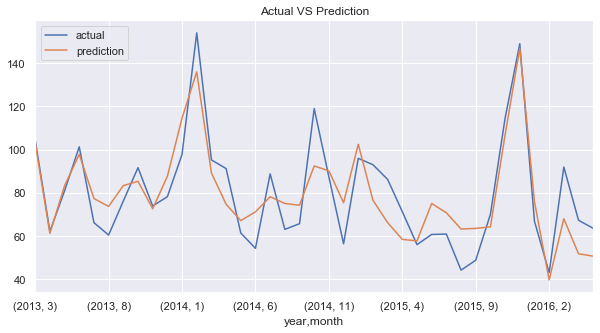

In [77]:
prediciton_vs_actual(X_train,y_train_actual,fixed_train_pre)

### Exam Test data 

In [78]:
fixed_params=[-64.17,
159.75,
226.68,
364.95,
283.29,
-90.73,
-3.35,
135.66,
-89.84,
64.98]

In [79]:
# obtian the prediction for test data 
fixed_test_pre=np.array(Fixed.predict(params=fixed_params, data=X_test)['predictions'])

In [80]:
# obtian the y_test data
y_test_actual=Y_test['PM2.5']

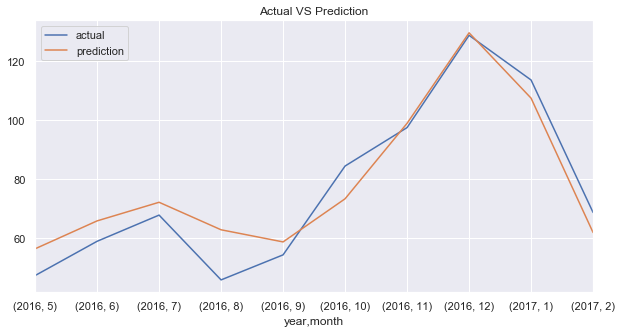

In [81]:
# prediction VS Actual for test data
prediciton_vs_actual(X_test,y_test_actual,fixed_test_pre)

In [82]:
Std_vs_RMSE(y_train_actual,fixed_train_pre),
Std_vs_RMSE(y_test_actual,fixed_test_pre)

Standard Diviation of actual values:80.44120645449095 
RMSE :46.35964728428138
Standard Diviation of actual values:82.94620524427543 
RMSE :40.87005818624045


## Random Effects

`Notes`

- The model is given by

$y_{it}=β′x_{it}+u_{i}+ϵ_{it}$
where $u_i$ is a shock that is independent of $x_{it}$  but common to all entities $i$.

In [83]:
from linearmodels import RandomEffects
random_effects=RandomEffects.from_formula('Y ~ 1 + SO2+NO2+CO+O3+TEMP+PRES+DEWP+RAIN+WSPM', data=paneldata)
random_res = random_effects.fit(cov_type='robust')
random_res

Dep. Variable:,Y,R-squared:,0.6740
Estimator:,RandomEffects,R-squared (Between):,-0.4854
No. Observations:,336612,R-squared (Within):,0.6754
Date:,"Sat, Mar 28 2020",R-squared (Overall):,0.6686
Time:,04:12:39,Log-likelihood,-1.765e+06
Cov. Estimator:,Robust,,
,,F-statistic:,7.732e+04
Entities:,12,P-value,0.0000
Avg Obs:,2.805e+04,Distribution:,"F(9,336602)"
Min Obs:,2.805e+04,,
Max Obs:,2.805e+04,F-statistic (robust):,3.735e+04


### train data  prediction

Standard Diviation of actual values:80.44120645449095 
RMSE :46.30893439930246
None


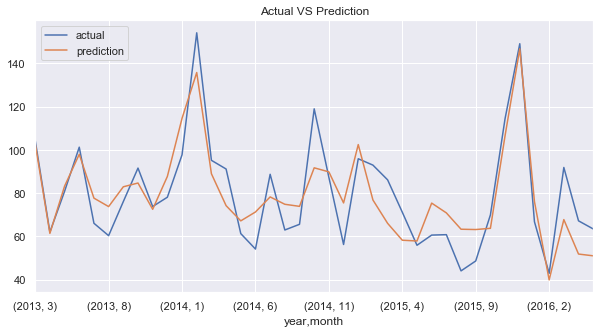

In [84]:
# Obtian prediction of train data and Y_train actual values
random_train_pre,y_train_actual=train_prediction_n_train_actual(random_res,Y_train)
print(Std_vs_RMSE(y_train_actual,random_train_pre))
prediciton_vs_actual(X_train,y_train_actual,random_train_pre)

### Exam test data 

In [85]:
random_params=[-58.60,
160.79,
218.83,
367.50,
281.26,
-93.66,
-7.60,
134.72,
-93.23,
62.91]

In [86]:
random_test_pre=np.array(Fixed.predict(params=random_params, data=X_test)['predictions'])

Standard Diviation of actual values:82.94620524427543 
RMSE :40.84605688584722
None


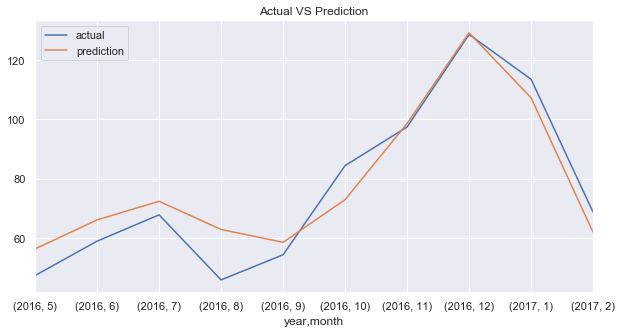

In [87]:
# list of random effects model parames and constant
print(Std_vs_RMSE(y_test_actual,random_test_pre))
prediciton_vs_actual(X_test,y_test_actual,random_test_pre)

In [88]:
Std_vs_RMSE(y_train_actual,random_train_pre),Std_vs_RMSE(y_test_actual,random_test_pre)

Standard Diviation of actual values:80.44120645449095 
RMSE :46.30893439930246
Standard Diviation of actual values:82.94620524427543 
RMSE :40.84605688584722


(None, None)

## Pooled OLS

- The model is given by

$y_{it}=β′x_{it}+ϵ_{it}$


In [89]:
# import packages - PooledOLS
from linearmodels import PooledOLS

pooled = PooledOLS.from_formula('Y ~ 1 + SO2+NO2+CO+O3+TEMP+PRES+DEWP+RAIN+WSPM', data=paneldata)
pooled_res = pooled.fit(cov_type='robust', cluster_entity=True)

In [90]:
pooled_res

Dep. Variable:,Y,R-squared:,0.6695
Estimator:,PooledOLS,R-squared (Between):,-0.1110
No. Observations:,336612,R-squared (Within):,0.6741
Date:,"Sat, Mar 28 2020",R-squared (Overall):,0.6695
Time:,04:12:45,Log-likelihood,-1.768e+06
Cov. Estimator:,Robust,,
,,F-statistic:,7.578e+04
Entities:,12,P-value,0.0000
Avg Obs:,2.805e+04,Distribution:,"F(9,336602)"
Min Obs:,2.805e+04,,
Max Obs:,2.805e+04,F-statistic (robust):,3.669e+04


### Train data prediction

Standard Diviation of actual values:80.44120645449095 
RMSE :46.30893439930246
None


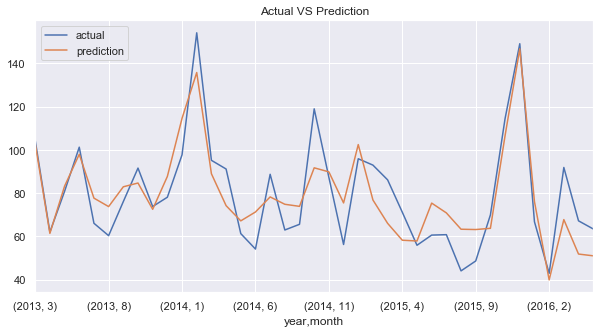

In [91]:
# Obtian prediction of train data and Y_train actual values
pooled_train_pre,y_train_actual=train_prediction_n_train_actual(random_res,Y_train)
print(Std_vs_RMSE(y_train_actual,pooled_train_pre))
prediciton_vs_actual(X_train,y_train_actual,pooled_train_pre)

### Exam test data

In [92]:
# list of params note: the first numner is the intercept 
pooled_params=[-42.45,
164.06,
194.14,
375.66,
274.68,
-102.19,
-19.63,
132.26,
-103.81,
56.94]

In [93]:
pooled_test_pre=np.array(pooled.predict(params=pooled_params, data=X_test)['predictions'])

Standard Diviation of actual values:82.94620524427543 
RMSE :40.86519318460021
None


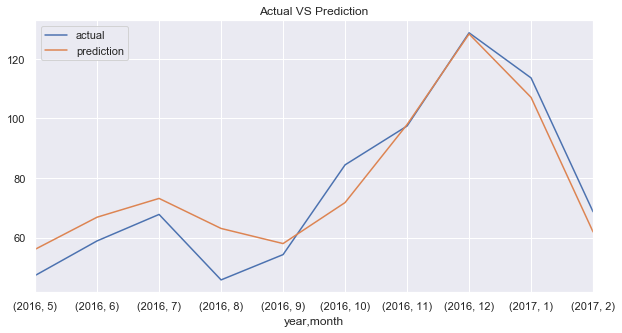

In [94]:
# list of pooled ols model parames and constant
print(Std_vs_RMSE(y_test_actual,pooled_test_pre))
prediciton_vs_actual(X_test,y_test_actual,pooled_test_pre)

In [95]:
Std_vs_RMSE(y_train_actual,pooled_train_pre),Std_vs_RMSE(y_test_actual,pooled_test_pre)

Standard Diviation of actual values:80.44120645449095 
RMSE :46.30893439930246
Standard Diviation of actual values:82.94620524427543 
RMSE :40.86519318460021


(None, None)

# Model Evaluation

## Compare RMSE

In [96]:
# fixed_Effect
Std_vs_RMSE(y_train_actual,fix_train_pre),
Std_vs_RMSE(y_test_actual,fixed_test_pre)

Standard Diviation of actual values:80.44120645449095 
RMSE :46.35964728428138
Standard Diviation of actual values:82.94620524427543 
RMSE :40.87005818624045


In [97]:
# random effect
Std_vs_RMSE(y_train_actual,random_train_pre),Std_vs_RMSE(y_test_actual,random_test_pre)

Standard Diviation of actual values:80.44120645449095 
RMSE :46.30893439930246
Standard Diviation of actual values:82.94620524427543 
RMSE :40.84605688584722


(None, None)

In [98]:
# pooled OLS
Std_vs_RMSE(y_train_actual,pooled_train_pre),Std_vs_RMSE(y_test_actual,pooled_test_pre)

Standard Diviation of actual values:80.44120645449095 
RMSE :46.30893439930246
Standard Diviation of actual values:82.94620524427543 
RMSE :40.86519318460021


(None, None)

In [99]:
from linearmodels.panel import compare
compare({'Fixed Effect':fixed_res,'Random Effects':random_res,'Pooled OLS':pooled_res})

,Fixed Effect,Random Effects,Pooled OLS
Dep. Variable,Y,Y,Y
Estimator,PanelOLS,RandomEffects,PooledOLS
No. Observations,336612,336612,336612
Cov. Est.,Robust,Robust,Robust
R-squared,0.6755,0.6740,0.6695
R-Squared (Within),0.6755,0.6754,0.6741
R-Squared (Between),-0.6230,-0.4854,-0.1110
R-Squared (Overall),0.6679,0.6686,0.6695
F-statistic,7.784e+04,7.732e+04,7.578e+04
P-value (F-stat),0.0000,0.0000,0.0000


##  Fixed effects (within) VS Pooling OLS (pFtest)

In [100]:
from PIL import Image

 `Note`
-  This test was taken in R.
-  Null hypothesis is : Pooling OSL estimator is bettern than Fixed estimator  
   if p-value < 0.05 which means Fixed effects model is a better choice

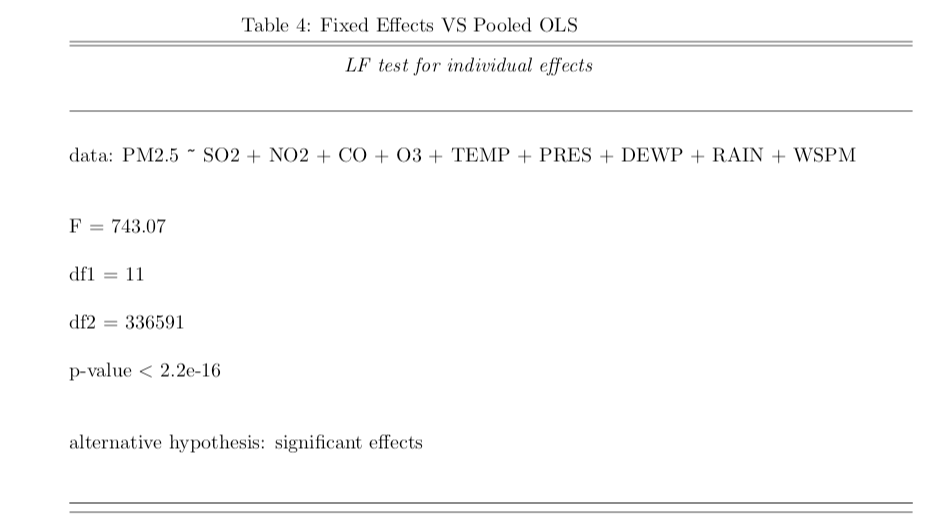

In [101]:
Image.open('fixed_vs_pooled.png')

`Since p-value < 0.05 that means fixed effects model is a better choice`

## Fixed effecs VS  Random (Hausman test phtest)

`Note`
- In panel data analysis (the analysis of data over time), the Hausman test can help you to choose between fixed effects model or a random effects model. The null hypothesis is that the preferred model is random effects; The alternate hypothesis is that the model is fixed effects.
- source:https://www.statisticshowto.datasciencecentral.com/hausman-test/

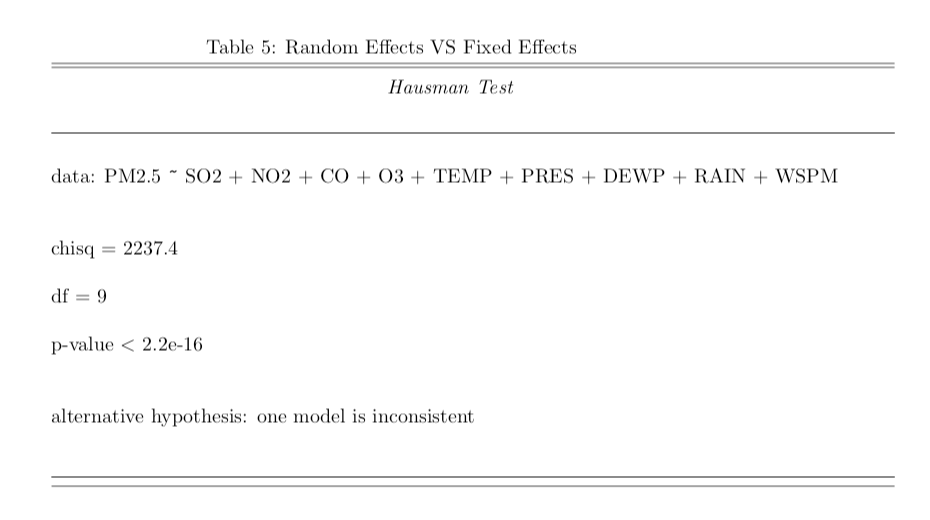

In [102]:
Image.open('random_vs_fixed.png')

`Our p-value is < 0.05, it rejects the null hypothesis so we choose fixed effects model.`

##  Radom  effects model vs Pooled OLS  (LMtest  plmtest)

`Note` 
- The LM test helps you decide between a random effects model and a pooled OLS model
- The null hypothesis in the LM test is that variances across entities is zero. This is, no significant difference across units (i.e. no panel effect)

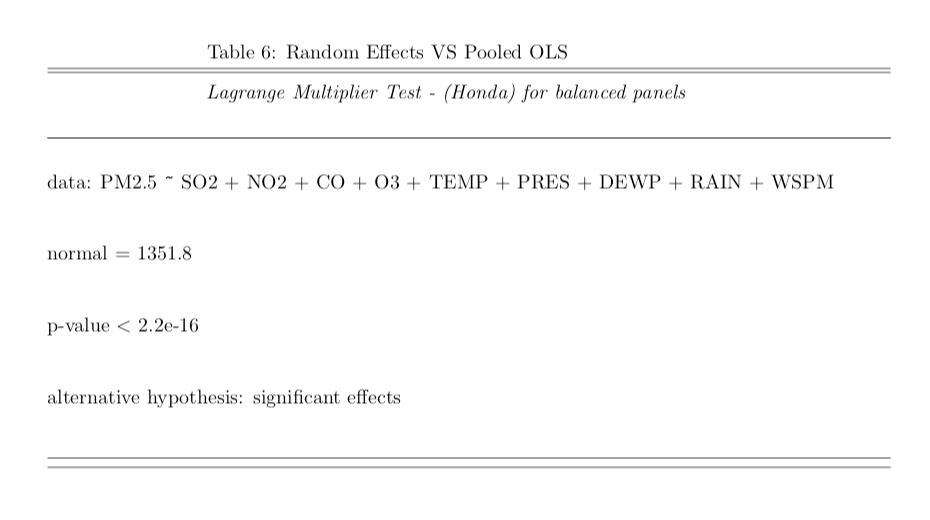

In [103]:
Image.open('random_vs_pooled.png')

 $p-value< 0.05 $
`Here we rejected the null and conclude that random effects is appropriate. This is, strong 
evidence of significant differences across countries, therefore we choose random effect model.`

  For our panel data  fixed effects model is best choice.